In [1]:
!pip install findspark

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, lit, sum as _sum

spark = SparkSession.builder \
    .appName("UAS_BigData_PUBG_Asyrof") \
    .getOrCreate() 

print("SparkSession berhasil diinisialisasi!")

path_abs = "file:///home/asyrof/Downloads/test_V2.csv"

df = spark.read.csv(path_abs, header=True, inferSchema=True)

print(f"Jumlah baris awal: {df.count()}")
df.printSchema()

25/11/27 12:19:00 WARN Utils: Your hostname, asyrof-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/11/27 12:19:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/27 12:19:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SparkSession berhasil diinisialisasi!


[Stage 2:============================================>              (3 + 1) / 4]

Jumlah baris awal: 1934174
root
 |-- Id: string (nullable = true)
 |-- groupId: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- assists: integer (nullable = true)
 |-- boosts: integer (nullable = true)
 |-- damageDealt: double (nullable = true)
 |-- DBNOs: integer (nullable = true)
 |-- headshotKills: integer (nullable = true)
 |-- heals: integer (nullable = true)
 |-- killPlace: integer (nullable = true)
 |-- killPoints: integer (nullable = true)
 |-- kills: integer (nullable = true)
 |-- killStreaks: integer (nullable = true)
 |-- longestKill: double (nullable = true)
 |-- matchDuration: integer (nullable = true)
 |-- matchType: string (nullable = true)
 |-- maxPlace: integer (nullable = true)
 |-- numGroups: integer (nullable = true)
 |-- rankPoints: integer (nullable = true)
 |-- revives: integer (nullable = true)
 |-- rideDistance: double (nullable = true)
 |-- roadKills: integer (nullable = true)
 |-- swimDistance: double (nullable = true)
 |-- teamKills: int

In [2]:
print("=== TAHAP 1: DATA CLEANING ===")

# --- 1. PROSES CLEANING ---
# Menggabungkan Drop Null dan 3 Filter Anomali dalam satu rantai eksekusi
df_clean = df.na.drop() \
    .filter(~((col("kills") > 0) & ((col("walkDistance") + col("rideDistance") + col("swimDistance")) == 0))) \
    .filter(~((col("kills") > 10) & (col("headshotKills") == col("kills")))) \
    .filter(col("swimDistance") < 2000) # Player AFK, CCheater, dan yang berenang lebih dari 2000 meter

# --- 2. TOTAL DATA ---
print(f"Status Data: {df.count()} (Awal) -> {df_clean.count()} (Setelah Cleaning)")

# --- 3. CONTOH OUTPUT  ---
output_cols = [
    "Id", "matchType", "kills", "damageDealt", "walkDistance", # 5 Kolom Umum
    "rideDistance", "swimDistance"                             # 2 Kolom Wajib
]

df_clean.select(output_cols).show(5, truncate=False)

=== TAHAP 1: DATA CLEANING ===


25/11/27 12:19:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

Status Data: 1934174 (Awal) -> 1933852 (Setelah Cleaning)
+--------------+---------+-----+-----------+------------+------------+------------+
|Id            |matchType|kills|damageDealt|walkDistance|rideDistance|swimDistance|
+--------------+---------+-----+-----------+------------+------------+------------+
|9329eb41e215eb|squad-fpp|0    |51.46      |588.0       |0.0         |0.0         |
|639bd0dcd7bda8|duo-fpp  |2    |179.1      |2017.0      |4669.0      |0.0         |
|63d5c8ef8dfe91|squad-fpp|0    |23.4       |787.8       |0.0         |0.0         |
|cf5b81422591d1|duo-fpp  |0    |65.52      |1812.0      |0.0         |0.0         |
|ee6a295187ba21|squad-fpp|3    |330.2      |2963.0      |0.0         |0.0         |
+--------------+---------+-----+-----------+------------+------------+------------+
only showing top 5 rows



In [3]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType, IntegerType

print("=== TAHAP 2: DATA PREPARATION ===")

# --- 1. FEATURE ENGINEERING & TRANSFORMASI ---

df_final_prep = df_clean.withColumn("totalDistance", col("walkDistance") + col("rideDistance") + col("swimDistance")) \
    .withColumn("itemsUsed", col("boosts") + col("heals")) \
    .withColumn("matchType_Norm", when(col("matchType").contains("squad"), "squad") \
                                 .when(col("matchType").contains("duo"), "duo") \
                                 .otherwise("solo")) \
    .drop("matchType", "Id", "groupId") # Hapus kolom id dan kategori lama
# Menggabungkan kategori: Total distance, Item used, Tipe match

# --- 2. TYPE CASTING ---
cast_cols = ["kills", "damageDealt", "maxPlace", "totalDistance", "itemsUsed", "headshotKills"]
for c in cast_cols:
    df_final_prep = df_final_prep.withColumn(c, col(c).cast(DoubleType()))
# Mengubah tipe data kolom fitur penting menjadi Double (Spark MLlib)

# --- 3. CONTOH OUTPUT OUTPUT  ---
output_view = ["kills", "damageDealt", "itemsUsed", "totalDistance",  "matchType_Norm"] 

df_final_prep.select(output_view).show(5, truncate=False)
df_final_prep.printSchema()

=== TAHAP 2: DATA PREPARATION ===
+-----+-----------+---------+-------------+--------------+
|kills|damageDealt|itemsUsed|totalDistance|matchType_Norm|
+-----+-----------+---------+-------------+--------------+
|0.0  |51.46      |0.0      |588.0        |squad         |
|2.0  |179.1      |6.0      |6686.0       |duo           |
|0.0  |23.4       |4.0      |787.8        |squad         |
|0.0  |65.52      |0.0      |1812.0       |duo           |
|3.0  |330.2      |5.0      |2963.0       |squad         |
+-----+-----------+---------+-------------+--------------+
only showing top 5 rows

root
 |-- matchId: string (nullable = true)
 |-- assists: integer (nullable = true)
 |-- boosts: integer (nullable = true)
 |-- damageDealt: double (nullable = true)
 |-- DBNOs: integer (nullable = true)
 |-- headshotKills: double (nullable = true)
 |-- heals: integer (nullable = true)
 |-- killPlace: integer (nullable = true)
 |-- killPoints: integer (nullable = true)
 |-- kills: double (nullable = true)
 

In [ ]:
# Instal numpy langsung di kernel yang sedang aktif
!pip install numpy

In [4]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col, percentile_approx, lit, when
import pandas as pd

print("=== TAHAP 3: NORMALISASI ULANG & FORMATING ===")

# --- 1. CONFIG & FEATURE SELECTION ---
# Fitur Input untuk ML (rideDistance DIKECUALIKAN agar tidak leakage)
ML_FEATURES = ["kills", "damageDealt", "itemsUsed", "totalDistance", "maxPlace", "swimDistance", "headshotKills"]

# Kolom yang ingin DITAMPILKAN di tabel
VIEW_COLS = ["kills", "damageDealt", "itemsUsed", "totalDistance", "maxPlace", "rideDistance", "swimDistance"]


# --- 2. PROSES NORMALISASI (SPARK) ---
# Hitung Threshold & Buat Label
ride_thresh = df_final_prep.select(percentile_approx("rideDistance", lit(0.95))).collect()[0][0]
df_labeled = df_final_prep.withColumn("label", when(col("rideDistance") > ride_thresh, 1.0).otherwise(0.0))

# Vector Assembler -> Standard Scaler
assembler = VectorAssembler(inputCols=ML_FEATURES, outputCol="features_vec")
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features", withStd=True, withMean=True)

# Pipeline Eksekusi
df_vec = assembler.transform(df_labeled)
df_scaled = scaler.fit(df_vec).transform(df_vec)
print("Proses Normalisasi Selesai.")


# --- 3. VISUALISASI PERBANDINGAN (PANDAS) ---
# Ambil sampel 5 baris & konversi ke Pandas
pdf = df_scaled.select(*VIEW_COLS, "scaled_features").sample(False, 0.1, seed=42).limit(5).toPandas()

# Format tampilan angka 2 desimal
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("\n>>> TABEL 1: DATA ORIGINAL (Sebelum Normalisasi)")
print(pdf[VIEW_COLS].to_markdown(index=False))

# Update nilai di dataframe pandas dengan nilai dari vektor yang sudah discaled
# Kita mapping index vektor ke nama kolom di ML_FEATURES
for i, col_name in enumerate(ML_FEATURES):
    if col_name in VIEW_COLS:
        # Timpa nilai asli dengan nilai dari dalam vektor scaled_features
        pdf[col_name] = pdf['scaled_features'].apply(lambda vec: vec[i])

print("\n>>> TABEL 2: DATA SCALED (Setelah Normalisasi)")
print("(Catatan: rideDistance tidak discale karena merupakan Target/Label)")
print(pdf[VIEW_COLS].to_markdown(index=False))

=== TAHAP 3: NORMALISASI ULANG & FORMATING ===


Proses Normalisasi Selesai.

>>> TABEL 1: DATA ORIGINAL (Sebelum Normalisasi)
|   kills |   damageDealt |   itemsUsed |   totalDistance |   maxPlace |   rideDistance |   swimDistance |
|--------:|--------------:|------------:|----------------:|-----------:|---------------:|---------------:|
|       0 |         68.61 |           0 |         1217    |         29 |            0   |           0    |
|       4 |        301    |           0 |          300.2  |         27 |            0   |           0    |
|       0 |        100    |           2 |          164.7  |         50 |            0   |           0    |
|       0 |          0    |           0 |          272    |         28 |            0   |           0    |
|       0 |          0    |           0 |         2365.49 |         49 |          398.4 |          36.09 |

>>> TABEL 2: DATA SCALED (Setelah Normalisasi)
(Catatan: rideDistance tidak discale karena merupakan Target/Label)
|     kills |   damageDealt |   itemsUsed |   totalDistan

In [ ]:
!pip install matplotlib seaborn
!pip install pandas seaborn

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Konversi Spark DataFrame ke Pandas (Hanya ambil 5% data sampel)
# seed=42 memastikan sampel yang diambil selalu sama setiap kali di-run
print("Mengambil sampel data...")
df_viz = df_final_prep.sample(False, 0.05, seed=42).toPandas()

print(f"Jumlah data untuk visualisasi: {len(df_viz)} baris")

# Set gaya visualisasi agar lebih cantik
sns.set(style="whitegrid")

Mengambil sampel data...


Jumlah data untuk visualisasi: 96536 baris


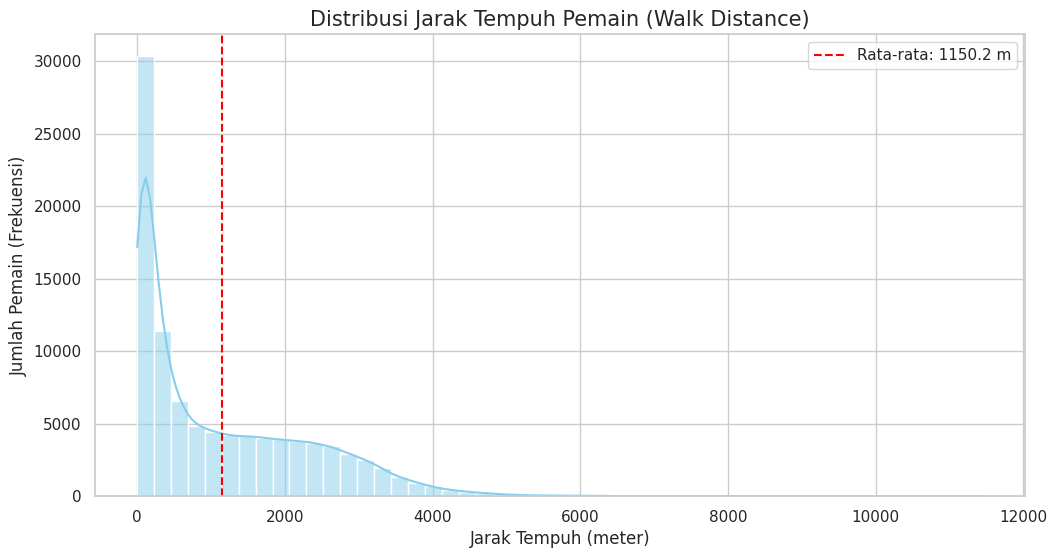

In [6]:
# --- VISUALISASI 1: HISTOGRAM (DISTRIBUSI) ---

plt.figure(figsize=(12, 6))

# Membuat Histogram dengan garis KDE (Kernel Density Estimate)
sns.histplot(
    data=df_viz, 
    x='walkDistance', 
    kde=True,       # Menampilkan garis kurva halus
    color='skyblue', 
    bins=50         # Jumlah batang diagram
)

plt.title('Distribusi Jarak Tempuh Pemain (Walk Distance)', fontsize=15)
plt.xlabel('Jarak Tempuh (meter)', fontsize=12)
plt.ylabel('Jumlah Pemain (Frekuensi)', fontsize=12)

# Menambahkan garis rata-rata (Mean)
mean_val = df_viz['walkDistance'].mean()
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Rata-rata: {mean_val:.1f} m')
plt.legend()

plt.show()

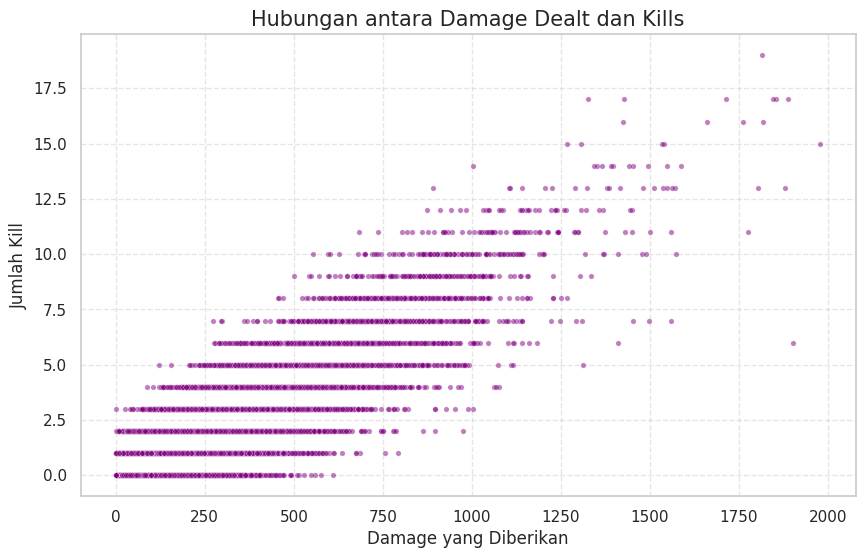

In [7]:
# --- VISUALISASI 2: SCATTER PLOT (KORELASI) ---

plt.figure(figsize=(10, 6))

# Kita filter data agar yang ditampilkan hanya yang memiliki Damage < 2000 
# (Untuk membuang outlier ekstrim agar grafik fokus ke pola utama)
df_scatter = df_viz[df_viz['damageDealt'] < 2000]

sns.scatterplot(
    data=df_scatter, 
    x='damageDealt', 
    y='kills', 
    alpha=0.5,      # Transparansi agar titik yang menumpuk terlihat
    color='purple',
    s=15            # Ukuran titik
)

plt.title('Hubungan antara Damage Dealt dan Kills', fontsize=15)
plt.xlabel('Damage yang Diberikan', fontsize=12)
plt.ylabel('Jumlah Kill', fontsize=12)

# Opsional: Tambahkan grid
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.sql.functions import col, percentile_approx, lit, when, count

print("=== KLASIFIKASI ROAD KING (RELIABLE) ===")

# --- A. PREPARATION & CLASS WEIGHTING ---

# Asumsi: df_final_prep (output dari Tahap 2) sudah tersedia

# 1. SAMPLING DATA (Wajib agar tidak OOM)
# Mengambil sampel 10% dari data bersih untuk training (190K baris)
print("[0/6] Mengambil sampel data (10%) untuk mencegah OOM error...")
df_sampled = df_final_prep.sample(False, 0.1, seed=42) 


# 2. Hitung Ambang Batas & Ciptakan Target (Label)
ride_distance_percentile = df_sampled.select(percentile_approx("rideDistance", lit(0.95))).collect()[0][0]

df_labeled = df_sampled.withColumn(
    "label",
    when(col("rideDistance") > ride_distance_percentile, 1.0).otherwise(0.0) 
).cache() # Cache data setelah dilabel


# 3. HITUNG RASIO BOBOT (Class Weighting)
df_counts = df_labeled.groupBy("label").count().collect()
count_0 = next((row['count'] for row in df_counts if row['label'] == 0.0), 0)
count_1 = next((row['count'] for row in df_counts if row['label'] == 1.0), 0)

weight_ratio = count_0 / count_1 # Contoh: 950K / 50K = 19.0
print(f"[1/6] Rasio Bobot Kelas 1 (Road King) = {weight_ratio:.2f}x")


# 4. BUAT KOLOM BOBOT BARU
df_weighted = df_labeled.withColumn(
    "classWeight",
    when(col("label") == 1.0, lit(weight_ratio)).otherwise(lit(1.0)) # Bobot 19x lipat untuk kelas minoritas
).cache() 


# --- B. NORMALISASI ULANG DAN PELATIHAN ---

# 5. Definisikan Fitur INPUT (Mencegah Data Leakage)
INPUT_FEATURES_CLEAN = [
    "kills", "damageDealt", "maxPlace", "itemsUsed", "headshotKills", 
    "walkDistance", "swimDistance", "assists", "revives" 
]

# 6. Vector Assembler & Standard Scaler
assembler_vehicle = VectorAssembler(inputCols=INPUT_FEATURES_CLEAN, outputCol="features_vehicle_vec")
df_vehicle_assembled = assembler_vehicle.transform(df_weighted) # Apply to weighted data

scaler_vehicle = StandardScaler(inputCol="features_vehicle_vec", outputCol="scaled_features", withStd=True, withMean=True)
scalerModel_vehicle = scaler_vehicle.fit(df_vehicle_assembled)
df_vehicle_scaled = scalerModel_vehicle.transform(df_vehicle_assembled)
print("[3/6] Normalisasi Ulang (Road King Safe) Selesai.")


# 7. SPLIT DATA
(trainingData, testData) = df_vehicle_scaled.randomSplit([0.8, 0.2], seed=42)


# 8. INISIALISASI MODEL DENGAN WEIGHTCOL (THE FIX)
lr = LogisticRegression(
    featuresCol="scaled_features", 
    labelCol="label", 
    weightCol="classWeight", # <-- MENGAKTIFKAN BOBOT KELAS DI PELATIHAN
    maxIter=10, 
    regParam=0.01 
)

# 9. TRAIN MODEL
print("[4/6] Melatih Model Logistic Regression dengan Class Weighting...")
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
print("Pelatihan & Prediksi Selesai.")


# --- C. EVALUASI METRIK AKHIR (CONFUSION MATRIX) ---

# 10. HITUNG CONFUSION MATRIX
predictionAndLabels = predictions.select("prediction", "label").rdd.map(
    lambda row: (float(row.prediction), float(row.label)) 
)
metrics = MulticlassMetrics(predictionAndLabels)

# Hitung Metrik Evaluasi
auc_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)


print("\n=== HASIL AKHIR KLASIFIKASI (SETELAH CLASS WEIGHTING) ===")
print(f"Area Under ROC (AUC): {auc:.4f}")
print(f"Akurasi Total: {metrics.accuracy:.4f}")
print("\n--- CONFUSION MATRIX ---")
print(metrics.confusionMatrix())
print("\n--- METRIK MINORITAS (Kelas 1 - Road King) ---")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1Score:.4f}")
print("==================================================")

=== KLASIFIKASI ROAD KING (RELIABLE) ===
[0/6] Mengambil sampel data (10%) untuk mencegah OOM error...


[1/6] Rasio Bobot Kelas 1 (Road King) = 18.96x


[3/6] Normalisasi Ulang (Road King Safe) Selesai.
[4/6] Melatih Model Logistic Regression dengan Class Weighting...


25/11/27 12:20:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

Pelatihan & Prediksi Selesai.


/home/asyrof/Downloads/Hadoop/spark-3.5.0-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
[Stage 56:>                                                         (0 + 4) / 4]


=== HASIL AKHIR KLASIFIKASI (SETELAH CLASS WEIGHTING) ===
Area Under ROC (AUC): 0.7958
Akurasi Total: 0.7288

--- CONFUSION MATRIX ---
DenseMatrix([[26696.,  9833.],
             [  589.,  1315.]])

--- METRIK MINORITAS (Kelas 1 - Road King) ---
Precision: 0.1180
Recall: 0.6907
F1 Score: 0.2015


/tmp/ipykernel_4012/3740797078.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


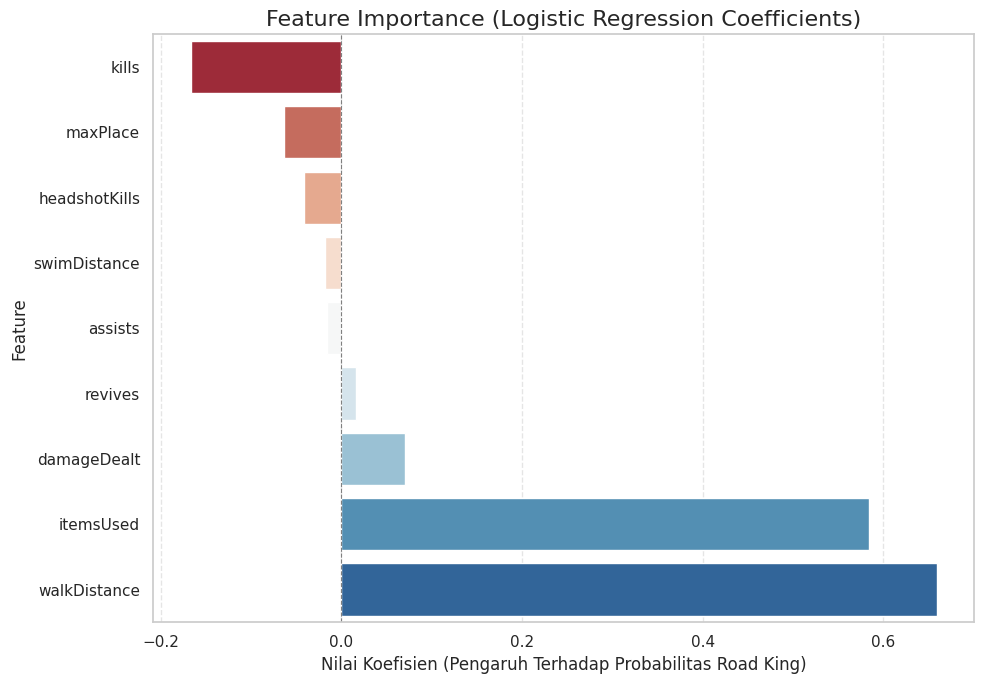

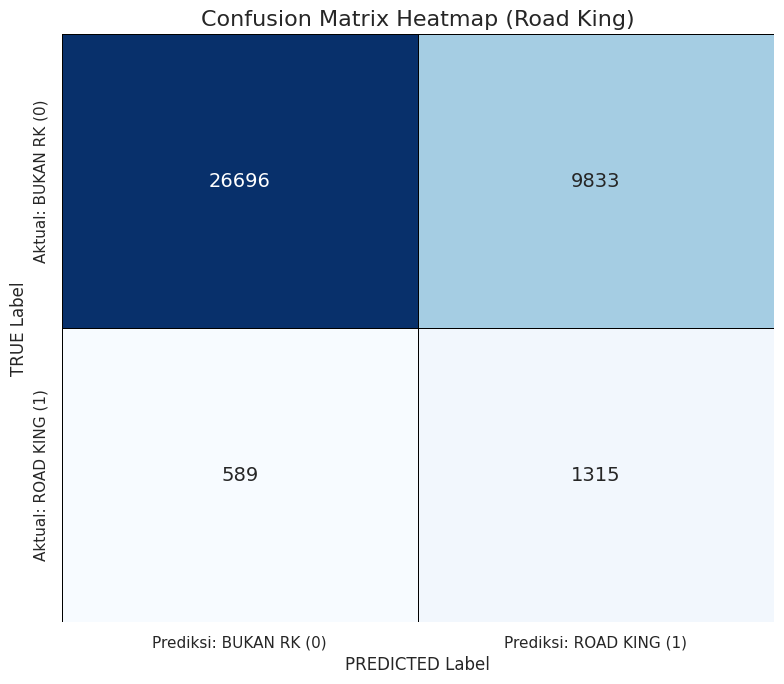

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set gaya visualisasi
sns.set(style="whitegrid")

# --- VISUALISASI 1: FEATURE IMPORTANCE (BAR CHART KOEFISIEN) ---

# 1.1. Ambil data dari Model Spark
coefficients = lrModel.coefficients.toArray()
# Daftar fitur yang digunakan dalam vektor (sesuai urutan assembler)
INPUT_FEATURES_CLEAN = [
    "kills", "damageDealt", "maxPlace", "itemsUsed", "headshotKills", 
    "walkDistance", "swimDistance", "assists", "revives" 
]

# 1.2. Buat Pandas DataFrame
feature_df = pd.DataFrame({
    'Feature': INPUT_FEATURES_CLEAN,
    'Coefficient': coefficients
})
feature_df['Abs_Coefficient'] = feature_df['Coefficient'].abs()
# Sortir berdasarkan koefisien (untuk Bar Chart yang rapi)
feature_df = feature_df.sort_values(by='Coefficient', ascending=True) 


# 1.3. Plotting Bar Chart
plt.figure(figsize=(10, 7))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=feature_df,
    palette='RdBu' # Warna yang membedakan Positif (Biru) dan Negatif (Merah)
)

plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
plt.title('Feature Importance (Logistic Regression Coefficients)', fontsize=16)
plt.xlabel('Nilai Koefisien (Pengaruh Terhadap Probabilitas Road King)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show() # Tampilkan Bar Chart


# --- VISUALISASI 2: CONFUSION MATRIX (HEATMAP) ---

# 2.1. Konversi DenseMatrix ke Array NumPy dan Pandas DataFrame
conf_matrix_np = metrics.confusionMatrix().toArray()
conf_matrix_df = pd.DataFrame(
    conf_matrix_np, 
    index=['Aktual: BUKAN RK (0)', 'Aktual: ROAD KING (1)'],
    columns=['Prediksi: BUKAN RK (0)', 'Prediksi: ROAD KING (1)']
)

# 2.2. Plotting Heatmap
plt.figure(figsize=(8, 7))
sns.heatmap(
    conf_matrix_df, 
    annot=True,         # Tampilkan angka di dalam sel
    fmt=".0f",          # Format angka menjadi bilangan bulat
    cmap="Blues",       # Skema warna
    cbar=False,         # Jangan tampilkan color bar
    linewidths=.5,      # Garis antar sel
    linecolor='black',
    annot_kws={"size": 14} 
)
plt.title('Confusion Matrix Heatmap (Road King)', fontsize=16)
plt.ylabel('TRUE Label', fontsize=12)
plt.xlabel('PREDICTED Label', fontsize=12)
plt.tight_layout()
plt.show() # Tampilkan Heatmap